In [1]:
import numpy as np
from sklearn.dummy import DummyClassifier
from sklearn.metrics import make_scorer, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.svm import SVC

In [2]:
logreg_param_grid = [{
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': np.logspace(-4, 4, 20),
    'solver': ['lbfgs', 'newton-cg', 'saga'],
    'max_iter' : [100, 1000],
    'l1_ratio': [0.5]
}]
svm_param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['rbf']
}

In [3]:
from src.utils import deserialize_data

X_train = deserialize_data("data/processed/X_train_ros.pkl")
y_train = deserialize_data("data/processed/y_train_ros.pkl")

X_valid = deserialize_data("data/processed/X_valid_prep.pkl")
y_valid = deserialize_data("data/interim/y_valid.pkl")

X_test = deserialize_data("data/processed/X_test_prep.pkl")
y_test = deserialize_data("data/interim/y_test.pkl")

In [4]:
logreg_model = LogisticRegression(n_jobs=-1)
svm_model = SVC()

In [5]:
def train_model(model, param_grid, X_train, y_train):
    """
    Trains the model with hyperparameters and returns the trained model.

    Parameters
    -----------
    model : Scikit's model

    hyperparameters : dict
        hyperparameters required by GridSearchCV

    X_train: dataframe
    		dataset's features for traing

    y_train: dataframe
    		dataset's label for training

    Returns
    -------
    base : RandomizedSearchCV
    	an RandomizedSearchCV object
    """
    k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=50)
    base = RandomizedSearchCV(
        estimator=model, param_distributions=param_grid,
        n_iter=50, scoring=make_scorer(precision_score, zero_division=0),
        n_jobs=-1, verbose=3, cv=k_fold, refit='precision',
    )

    base.fit(X_train, y_train)

    return base

In [6]:
logreg_base = train_model(logreg_model, logreg_param_grid, X_train, y_train)
svm_base = train_model(svm_model, svm_param_grid, X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/rudi/Documents/pacmann/ML API/machine-learning-process/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/rudi/Documents/pacmann/ML API/machine-learning-process/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/rudi/Documents/pacmann/ML API/machine-learning-process/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/rudi/Documents/pacmann/ML API/machine-learning-process/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/rudi/Document

In [7]:
from src.utils import serialize_data


serialize_data(logreg_base, "models/logreg_base.pkl")
serialize_data(svm_base, "models/svm_base.pkl")

In [8]:
logreg_estimator = logreg_base.best_estimator_
svm_estimator = svm_base.best_estimator_

In [9]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import precision_score


def tune_threshold(model, x_data, y_data):
    model_name = model.__class__.__name__
    y_probabilities = model.predict_proba(x_data)[:, 1]

    scores = []
    thresholds = []

    for threshold in np.linspace(0, 1, 100):
        y_predictions = (y_probabilities >= threshold).astype(int)

        score = precision_score(y_data, y_predictions, zero_division=0)

        scores.append(score)
        thresholds.append(threshold)

    calculated_thresholds = {
        'model': model_name,
        'metric': 'precision',
        'thresholds': thresholds,
        'scores': scores,
    }

    plt.figure(figsize=(12, 8))
    plt.title(f'Precision Scores for {model}')
    plt.plot(thresholds, scores, label='Precision Scores')
    plt.xlabel('Threshold')
    plt.ylabel('Precision Score')
    plt.legend()
    plt.grid()
    plt.show()

    return calculated_thresholds


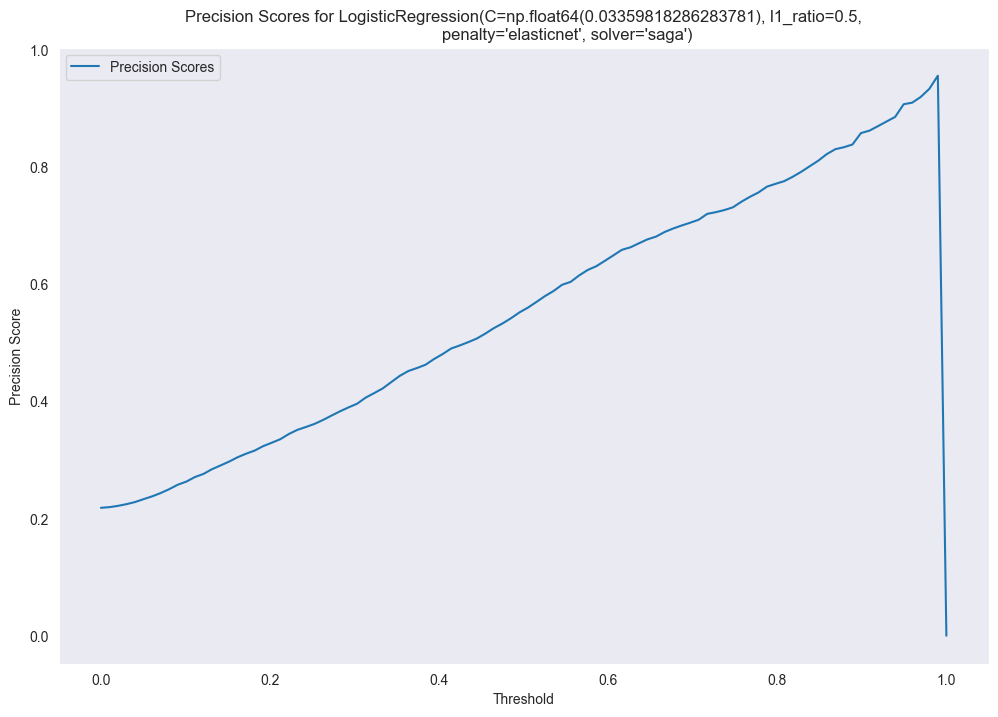

In [10]:
logreg_threshold = tune_threshold(logreg_estimator, X_valid, y_valid)
svm_threshold = tune_threshold(svm_estimator, X_test, y_test)

In [11]:
threshold_list = [logreg_threshold, svm_threshold]

In [12]:
import json


def calculate_best_threshold(thresholds):
    best_threshold = thresholds.pop()
    for threshold in thresholds:
        if threshold['highest_score'] > best_threshold['highest_score']:
            best_threshold = threshold

    return best_threshold


def get_best_threshold(thresholds, path):
    calculated_threshold = []
    for threshold in thresholds:
        model = threshold['model']
        metric = threshold['metric']
        thresholds_ = threshold['thresholds']
        scores = threshold['scores']

        # find the best threshold from the highest score
        highest_score = max(scores)
        index_of_highest_score = scores.index(highest_score)
        best_threshold_ = thresholds_[index_of_highest_score]

        calculated_threshold.append({
            'model': model,
            'highest_score': highest_score,
            'threshold': best_threshold_,
            'metric': metric,
        })

    best_threshold = calculate_best_threshold(calculated_threshold)
    with open(path, 'w') as f:
        json.dump(best_threshold, f)

    return best_threshold

In [13]:
best_threshold = get_best_threshold(threshold_list, "models/best_threshold.json")

In [14]:
from sklearn.metrics import classification_report, precision_score

def evaluate_model(model, threshold, x_data, y_data):
    print("Best Threshold : ", threshold)

    threshold = threshold['threshold']
    y_predicted = (model.predict_proba(x_data)[:, 1] >= threshold).astype(int)

    print(classification_report(y_data, y_predicted))


In [15]:
evaluate_model(logreg_estimator, best_threshold, X_test, y_test)

Best Threshold :  {'model': 'LogisticRegression', 'highest_score': 0.9565217391304348, 'threshold': np.float64(0.98989898989899), 'metric': 'precision'}
              precision    recall  f1-score   support

           0       0.77      1.00      0.87       998
           1       1.00      0.05      0.09       306

    accuracy                           0.78      1304
   macro avg       0.89      0.52      0.48      1304
weighted avg       0.83      0.78      0.69      1304

